In [ ]:
import os
import logging
import speech_recognition as sr
from pydub import AudioSegment
from langchain_ollama import ChatOllama
#from langchain_community.chat_models import ChatOllama
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser 

In [ ]:
def convert_audio_to_wav(audio_path: str) -> str:
    """
    Convert an audio file to WAV format with a sample rate of 16000 Hz,
    which is better suited for the Google Speech Recognition API.
    If the file is already in WAV format, returns the original path.
    """
    if audio_path.lower().endswith('.wav'):
        return audio_path
    new_path = os.path.splitext(audio_path)[0] + "_converted.wav"
    try:
        audio = AudioSegment.from_file(audio_path)
        audio = audio.set_frame_rate(16000)
        audio.export(new_path, format="wav")
        logging.info(f"Converted audio file saved as: {new_path}")
        return new_path
    except Exception as e:
        logging.error(f"Error converting audio file to WAV: {e}")
        raise

In [ ]:
def transcribe_audio_google(audio_path: str) -> str:
    """
    Transcribe audio using SpeechRecognition's Google API.
    Note: This uses Google's free web API, which has usage limits.
    """
    recognizer = sr.Recognizer()
    try:
        with sr.AudioFile(audio_path) as source:
            audio_data = recognizer.record(source)
        transcription = recognizer.recognize_google(audio_data)
        logging.info("Transcription successful.")
        return transcription
    except Exception as e:
        logging.error(f"Error transcribing audio: {str(e)}")
        raise

In [ ]:
def call_slm_with_transcription(transcription: str, query: str) -> str:
    """
    Format the prompt with the transcription and user query,
    then pass it to the SLM (granite3-dense:2b) using ChatOllama.
    """
    prompt_template = ChatPromptTemplate.from_template(
        """Below is the transcript of an audio file:
        
{transcription}

Now, answer the following question based on the transcript:
{question}

If you are not sure, say you don't know."""
    )
    
    llm = ChatOllama(model="granite3-dense:2b", temperature=0)

    chain = prompt_template | llm

    response = chain.invoke({
        "transcription": transcription,
        "question": query
    })
    
    return response.content

In [ ]:
def main():
    logging.basicConfig(level=logging.INFO)

    audio_path = "C://Users//prana//Downloads//New folder (2)//Bank account prank recording.mp3"
    
    if not os.path.exists(audio_path):
        logging.error(f"Audio file not found at: {audio_path}")
        return
    
    try:
        logging.info("Converting audio file to WAV format (if needed)...")
        wav_path = convert_audio_to_wav(audio_path)
    except Exception as e:
        logging.error("Failed to convert audio: " + str(e))
        return

    try:
        logging.info("Transcribing audio using Google Speech Recognition...")
        transcription = transcribe_audio_google(wav_path)
        logging.info(f"Transcription:\n{transcription}")
    except Exception as e:
        logging.error("Error during transcription: " + str(e))
        return

    try:
        user_query = input("Enter your query about the audio: ").strip()
        logging.info("Calling SLM with the transcription and query...")
        result = call_slm_with_transcription(transcription, user_query)
        print("\nResult:", result)
    except Exception as e:
        logging.error("Error calling SLM: " + str(e))
        
if __name__ == "__main__":
    main()

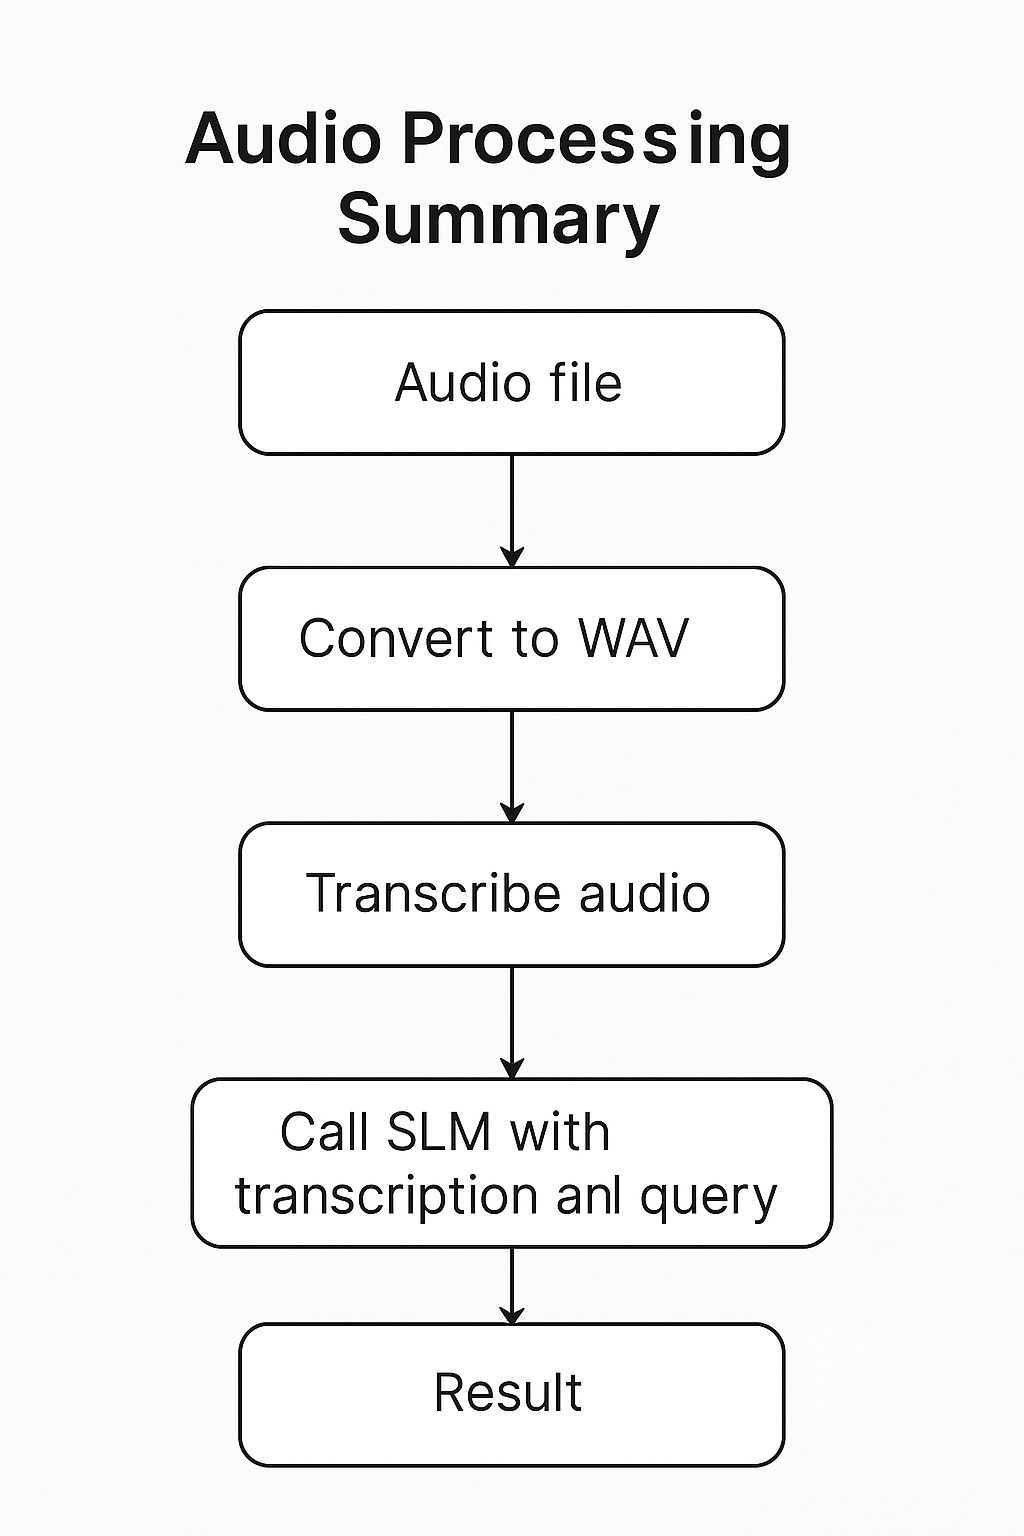